In [1]:
import copy
from derivative import dxdt
import random
import os
import sys
sys.path.append('/home/xie/projects/PyDimension')

import pandas as pd
import pysindy as ps
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from numpy.linalg import matrix_rank
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import r2_score

from utils.tvregdiff.tvregdiff import TVRegDiff
from utils.tvregdiff.poly_diff import PolyDiff, PolyDiffPoint
from utils.tvregdiff.STRidge import TrainSTRidge, print_pde

%matplotlib inline
plt.rcParams["font.family"] = "Arial"
np.set_printoptions(suppress=True)

In [2]:
# create a folder to save results
if not os.path.exists('../results'):
    os.mkdir('../results')

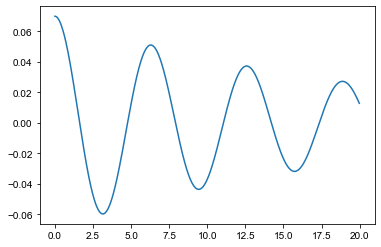

In [3]:
class SpringMassDataset(object):
    '''
    Generate data for spring-mass-damping systems
    '''
    def __init__(self, k, m, A0, c, v0=0, et=20, Nt=800):
        super(SpringMassDataset, self).__init__()
        self.k = k
        self.m = m
        self.A0 = A0
        self.c = c
        self.et = et
        self.v0 = v0
        self.Nt = Nt

        self.omega_n = np.sqrt(k / m)
        self.xi = c / 2 / np.sqrt(m * k)
        self.omega_d = self.omega_n * np.sqrt(1 - self.xi**2)
        self.A = np.sqrt(A0**2 + ((v0 + self.xi * self.omega_n * A0) / self.omega_d)**2)
        self.phi = np.arctan(self.omega_d * A0 / (v0 + self.xi * self.omega_n * A0))

    def solution(self):
        t = np.linspace(0, self.et, self.Nt, endpoint=False)
        x = self.A * np.exp(-self.xi * self.omega_n * t) * np.sin(self.omega_d * t + self.phi)
        info = {'t': t, 'x': x}
        df = pd.DataFrame(info)
        return df
    
k, m, A0, c, et, Nt = 0.2, 0.2, 0.07, 0.02, 20, 1000
dataset = SpringMassDataset(k, m, A0, c)
data_old = dataset.solution()
fig = plt.figure()
plt.plot(data_old['t'], data_old['x'])

# Dataset preparation

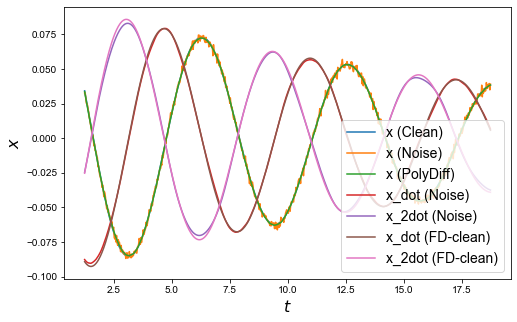

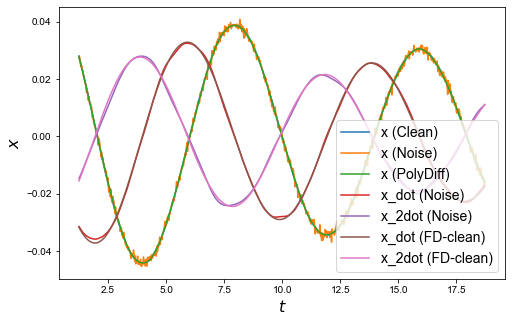

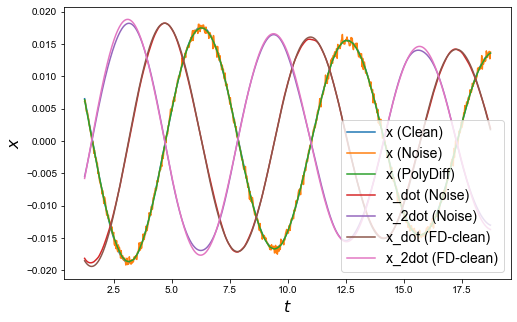

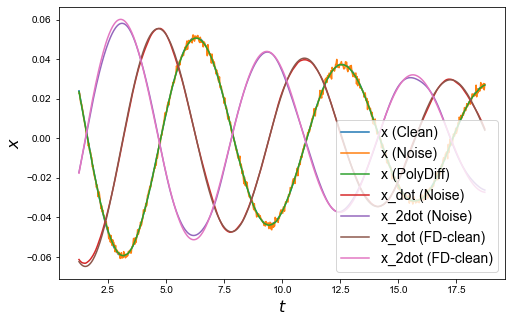

In [4]:
class FitEqu(object):
    '''
    For a given data, fit the governing equation.
    '''
    
    def __init__(self):
        super(FitEqu, self).__init__()
        
    def prepare_data(self):
        '''
        generate the dataset
        '''
        dataset = SpringMassDataset(self.k, self.m, self.A0, self.c)
        return dataset.solution()  # a dataFrame
    
    def prepare_library(self, data):
        '''
        prepare library for regression
        '''
        is_poly, remove_num = False, 50  # remove some points at the first and end
        t, x_clean = data['t'].to_numpy(), data['x'].to_numpy()
        
        # add noize 
        np.random.seed(0)
        x_noise = x_clean + np.random.normal(0, np.std(x_clean), x_clean.shape) * 0.04
        
        # fit a polynomial function to reconstruct data
        width, deg, diff, is_poly = 30, 3, 2, True
        x_fit, x_12dot = PolyDiff(x_noise, t, width=width, deg=deg, diff=diff)
        x_12dot = x_12dot.reshape(-1, 2)
        # uncomment these two lines if you want to use polynomial's derivatives
        # x_dot = x_12dot[:,0]
        # x_2dot = x_12dot[:,1]
        
        # use TVRegDiff to calcualte derivatives
        x_dot = TVRegDiff(x_noise, 1, 0.4, dx=t[1]-t[0], plotflag=False, diffkernel='sq')
        x_2dot = TVRegDiff(x_dot, 1, 0.4, dx=t[1]-t[0], plotflag=False, diffkernel='sq')
        x_dot, x_2dot = x_dot[width:-width], x_2dot[width:-width]
        
        # finite difference for clean data
        x_dot_FD = dxdt(x_clean, t, kind="finite_difference", k=1)
        x_2dot_FD = dxdt(x_dot_FD, t, kind="finite_difference", k=1)
        x_dot_FD = x_dot_FD[remove_num:-remove_num]
        x_2dot_FD = x_2dot_FD[remove_num:-remove_num]
        
        # remove some data in the first and end
        t = t[remove_num:-remove_num]
        x_noise = x_noise[remove_num:-remove_num]
        x_clean = x_clean[remove_num:-remove_num]
        if not is_poly:
            x_dot = x_dot[remove_num:-remove_num]
            x_2dot = x_2dot[remove_num:-remove_num].reshape(-1,)
        else:
            x_dot = x_dot[remove_num-width:-(remove_num-width)].reshape(-1,)
            x_2dot = x_2dot[remove_num-width:-(remove_num-width)].reshape(-1,)
            x_fit = x_fit[remove_num-width:-(remove_num-width)].reshape(-1,)

        # plot
        fig = plt.figure(figsize=(8, 5))
        plt.plot(t, x_clean, label='x (Clean)')
        plt.plot(t, x_noise, label='x (Noise)')
        if is_poly:
            plt.plot(t, x_fit, label='x (PolyDiff)')
        plt.plot(t, x_dot, label='x_dot (Noise)')
        plt.plot(t, x_2dot, label='x_2dot (Noise)')
        plt.plot(t, x_dot_FD, label='x_dot (FD-clean)')
        plt.plot(t, x_2dot_FD, label='x_2dot (FD-clean)')
        plt.legend(fontsize=14, loc=4); 
        plt.xlabel(r'$t$', fontsize=16)
        plt.ylabel(r'$x$', fontsize=16)
        
        # fit regression
        X_library = np.stack((x_fit, x_fit**2, x_2dot, 
                np.multiply(x_fit.reshape(-1, 1), x_dot.reshape(-1, 1)).reshape(-1,)), axis=-1)
        y_library = x_dot
       
        return X_library, y_library
    
    def fit(self, k, m, A0, c, threshold=0.05):
        '''
        fit the equation
        '''
        # preperation for dataset used for regression
        self.k, self.m, self.A0, self.c, self.threshold = k, m, A0, c, threshold
        data = self.prepare_data()
        X_library, y_library = self.prepare_library(data)
        # ################################squential threshold################################
        # initialize a linear regression model
        model = LinearRegression(fit_intercept=True)
        model.fit(X_library, y_library)
        r2_train = model.score(X_library, y_library)

        # loops for 3 iterations to find a sparse coefficients
        for i in range(3):
            coef = model.coef_
            flag = np.repeat((np.abs(coef) > threshold).astype(int).reshape(1,-1), 
                             X_library.shape[0], axis=0)
            X1 = copy.copy(X_library)
            X1 = np.multiply(X1, flag)
            model.fit(X1, y_library)
            r2_train = model.score(X1, y_library)
        coef = np.squeeze(model.coef_)

        # ################################post-process################################
        coef = np.squeeze(coef)
        k_pred = round(-coef[0] * c, 4)
        m_pred = round(-coef[2] * c, 4)
        k_pred_list = [round(i, 4) for i in coef.tolist()]
        m_pred_list = [round(i, 4) for i in coef.tolist()]
        return coef[0], coef[2], coef
    
def prepare_dataset():
    '''
    prepare a sets of dataset
    '''
    data = []
    fit_equ = FitEqu()
    params = [
        [1, 1, 0.1, 0.1],
        [0.5, 0.8, 0.05, 0.05],
        [0.1, 0.1, 0.02, 0.004],
        [0.2, 0.2, 0.07, 0.02],
    ]
    for k, m, A0, c in params:
        k_coef, c_coef, coef_all = fit_equ.fit(k, m, A0, c, threshold=0.6)
        data.append([m, k, A0, c, k_coef, c_coef, k_coef+k/c, c_coef+m/c, 
                        np.abs((k_coef+k/c)/(k/c))*100, np.abs((c_coef+m/c)/(m/c))*100])
        
    df = pd.DataFrame(
        data, columns=['m', 'k', 'A0', 'c', 'k_coef', 'm_coef', 
                       'k_coef+k/c', 'm_coef+m/c', 'RAE_k(%)', 'RAE_m(%)'])
    return df

df = prepare_dataset()

In [5]:
print(df[:10])
print(df.describe()[['RAE_k(%)', 'RAE_m(%)']])
df.to_csv('../results/discover_equation_spring_data.csv')

     m    k    A0      c     k_coef     m_coef  k_coef+k/c  m_coef+m/c  \
0  1.0  1.0  0.10  0.100 -10.659644 -10.878647   -0.659644   -0.878647   
1  0.8  0.5  0.05  0.050  -9.125514 -14.693851    0.874486    1.306149   
2  0.1  0.1  0.02  0.004 -24.809215 -25.334046    0.190785   -0.334046   
3  0.2  0.2  0.07  0.020 -10.659668 -10.878668   -0.659668   -0.878668   

   RAE_k(%)  RAE_m(%)  
0  6.596440  8.786471  
1  8.744858  8.163432  
2  0.763139  1.336184  
3  6.596675  8.786680  
       RAE_k(%)  RAE_m(%)
count  4.000000  4.000000
mean   5.675278  6.768192
std    3.427776  3.633233
min    0.763139  1.336184
25%    5.138115  6.456620
50%    6.596558  8.474951
75%    7.133721  8.786523
max    8.744858  8.786680


# Recover k

In [6]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_coef, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_coef = output_coef
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_coef].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in = self.basis_list[0], self.basis_list[1]
        return basis1_in, basis2_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + self.basis2_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def fit_pattern_search(self, seed):
        '''
        pattern search
        '''
        def get_coordinates(a, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for a_ in [a-delta, a, a+delta]:
                if [a_] != [a]:
                    coord_all.append([a_])
            return coord_all
        
        def opt(coef):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(pi_in, self.y)
            y_pred = reg.predict(pi_in)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        # a= 0
        coef = np.array([a]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 10, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a])
                break

            r2_bounds_val = []
            for [a_] in candidate_coord:
                coef_temp = np.array([a_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a] = candidate_coord[highest_index]
                coef = np.array([a]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef_final, coef_w_final = opt(coef)
        return r2, reg_coef_final, coef_w_final


def recover_coef1(seed):
    input_list = ['m', 'k', 'A0', 'c']
    output_coef = 'm_coef'

    D_in = np.mat('1, 0, 0; 1, 0, -2; 0, 1, 0; 1, 0, -1').T
    D_out = np.mat('0;, 0; 1')
    dimension_info = [D_in, D_out]

    basis1_in = np.array([1, 1, 0, -2]).reshape(-1, 1)
    basis2_in = np.array([1, 0, 0, -1]).reshape(-1, 1)
    basis_list = [basis1_in, basis2_in]
    
    dimensionless_learning = DimensionlessLearning(
        df, input_list, output_coef, dimension_info, basis_list)

    # pattern search
    r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
    if r2 > 0.8:
        print('final r2', r2, coef.flatten(), coef_w)


for i in range(20):
    recover_coef1(seed=i)

final r2 0.9761651201269569 [ 1.  0.  0. -1.] [[-1.00464932]]
final r2 0.9761651201269569 [ 1.  0.  0. -1.] [[-1.00464932]]


# Recover -k/c

In [7]:
def recover_coef2(seed):
    input_list = ['m', 'k', 'A0', 'c']
    output_coef = 'k_coef'

    D_in = np.mat('1, 0, 0; 1, 0, -2; 0, 1, 0; 1, 0, -1').T
    D_out = np.mat('0;, 0; -1')
    dimension_info = [D_in, D_out]

    basis1_in = np.array([1, 1, 0, -2]).reshape(-1, 1)
    basis2_in = np.array([0, 1, 0, -1]).reshape(-1, 1)
    basis_list = [basis1_in, basis2_in]
    
    dimensionless_learning = DimensionlessLearning(
        df, input_list, output_coef, dimension_info, basis_list)

    # pattern search
    r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
    if r2 > 0.8:
        print('final r2', r2, coef.flatten(), coef_w)


for i in range(20):
    recover_coef2(seed=i)

final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
final r2 0.9897325188183652 [ 0.  1.  0. -1.] [[-0.99965259]]
